In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

from nilearn.image import mean_img, get_data 
from nilearn.input_data import NiftiMasker
from nilearn import datasets, plotting, image
from nilearn.plotting import plot_anat, show, plot_stat_map, plot_matrix, plot_roi, plot_epi
from matplotlib.patches import Rectangle
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, cross_val_score, GridSearchCV

#import nilearn.image as image

%matplotlib inline

In [2]:
# Fetching dataset
haxby_ds = datasets.fetch_haxby(subjects=[4], fetch_stimuli=True)

In [3]:
haxby_ds.keys()

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])

In [4]:
# Read the data documentation
print(haxby_ds['description'].decode('utf-8'))

Haxby 2001 results


Notes
-----
Results from a classical fMRI study that investigated the differences between
the neural correlates of face versus object processing in the ventral visual
stream. Face and object stimuli showed widely distributed and overlapping
response patterns.

Content
-------
The "simple" dataset includes
    :'func': Nifti images with bold data
    :'session_target': Text file containing session data
    :'mask': Nifti images with employed mask
    :'session': Text file with condition labels


The full dataset additionally includes
    :'anat': Nifti images with anatomical image
    :'func': Nifti images with bold data
    :'mask_vt': Nifti images with mask for ventral visual/temporal cortex
    :'mask_face': Nifti images with face-reponsive brain regions
    :'mask_house': Nifti images with house-reponsive brain regions
    :'mask_face_little': Spatially more constrained version of the above
    :'mask_house_little': Spatially more constrained version of the abov

## Plotting the used stimuli Haxby dataset

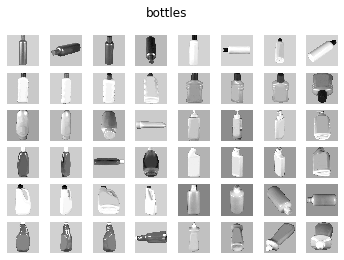

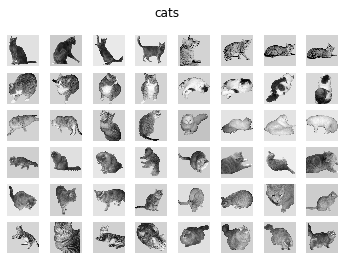

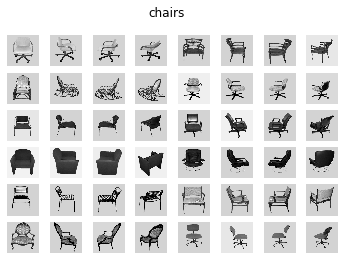

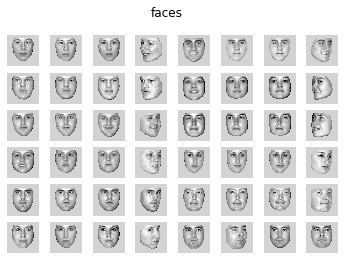

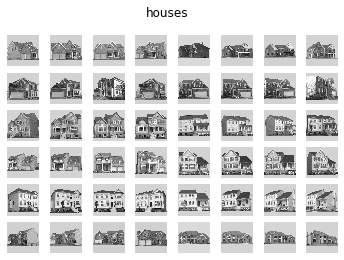

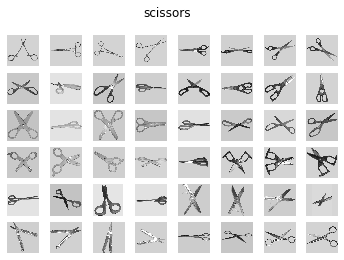

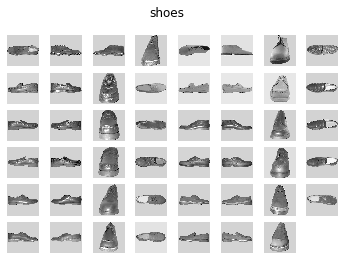

In [5]:
stimulus_info = haxby_ds.stimuli

for stim_type in stimulus_info:
    # skip control images, there are too many
    if stim_type != 'controls':

        file_names = stimulus_info[stim_type]

        fig, axes = plt.subplots(6, 8)
        fig.suptitle(stim_type)

        for img_path, ax in zip(file_names, axes.ravel()):
            ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)

        for ax in axes.ravel():
            ax.axis("off")

## Visualizing the fMRI volume

In [6]:
mask_house_file = haxby_ds.mask_house[0]
mask_face_file = haxby_ds.mask_face[0]
mask_vt_file = haxby_ds.mask_vt[0]
func_file = haxby_ds.func[0]
anat_file = haxby_ds.anat[0]

mean_img = image.mean_img(func_file)

**Plotting the functional image:**

/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



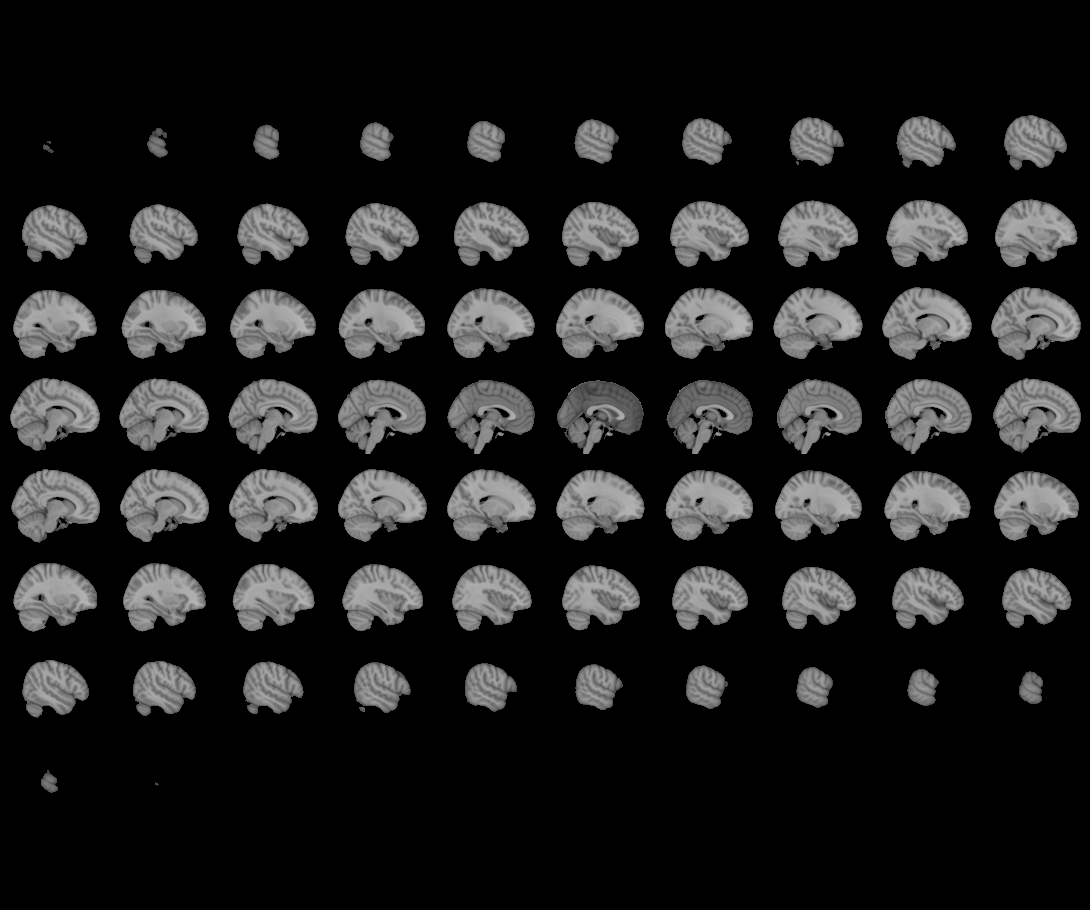
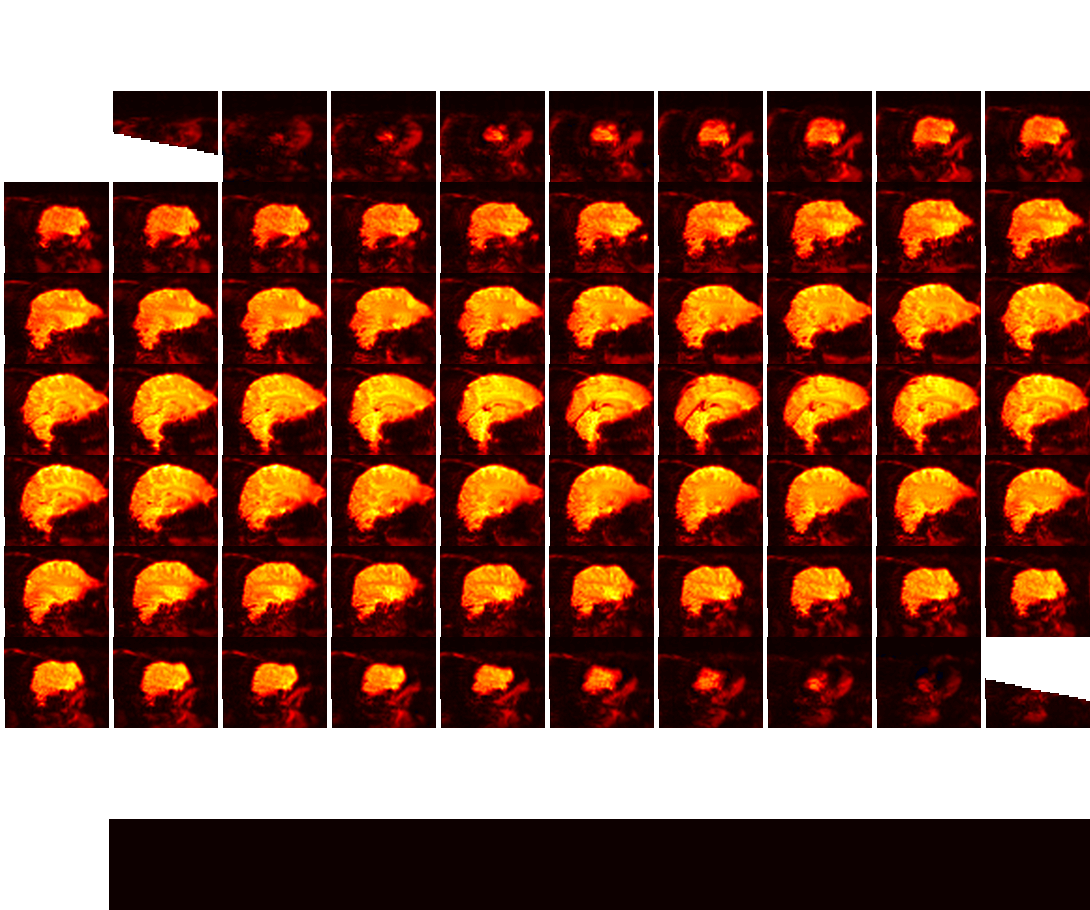

In [7]:
# Load the functional image
img = nib.load(haxby_ds['func'][0])

# Take a look at the first time point
plotting.view_img(image.index_img(img, 2))

**Plotting the ROI:**

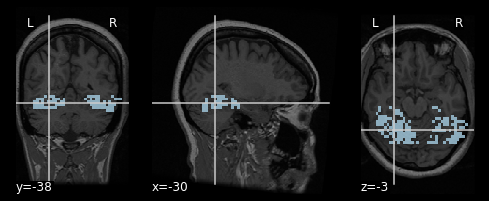

In [8]:
# Feature extraction from fMRI volumes to a data matrix (background is anatomical scan)

mask_vt_file = haxby_ds.mask_vt[0]

plotting.plot_roi(mask_vt_file, bg_img=anat_file, cmap='Paired', black_bg='true', alpha=0.8)

**Plotting the masks:**

/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: The following kwargs were not used by contour: 'contours'
  **kwargs)


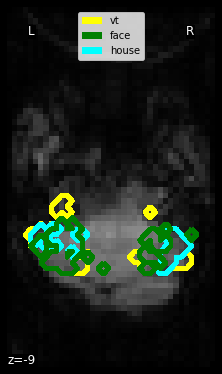

In [9]:
z_slice = -9

fig = plt.figure(figsize=(4, 5), facecolor='k' )

display = plot_anat(mean_img, display_mode='z', cut_coords=[z_slice], figure=fig)

display.add_contours(mask_vt_file, contours=0.7, antialiased=False, linewidths=4., levels=[0], colors=['yellow'])
display.add_contours(mask_face_file, contours=0.7, antialiased=False, linewidths=4., levels=[0], colors=['cyan'])
display.add_contours(mask_house_file, contours=0.7, antialiased=False, linewidths=4., levels=[0], colors=['green'])

p_v = Rectangle((0, 0), 1, 1, fc="yellow")
p_f = Rectangle((0, 0), 1, 1, fc="cyan")
p_h = Rectangle((0, 0), 1, 1, fc="green")

plt.legend([p_v, p_h, p_f], ["vt", "face", "house"], loc='upper center' )

**NiftiMasker:**

First functional nifti image (4D) is located at: /home/srastegarnia/nilearn_data/haxby2001/subj4/bold.nii.gz


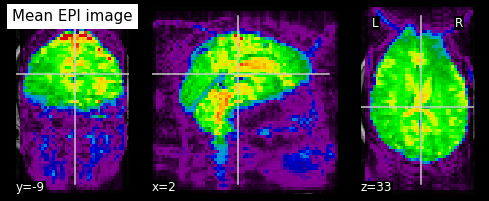

In [10]:
# func_file = haxby_ds.func[0]
#miyawaki_filename = miyawaki_dataset.func[0]

# print basic information on the dataset
print('First functional nifti image (4D) is located at: %s' % haxby_ds.func[0])  # 4D data

mean_img = image.mean_img(func_file)
#miyawaki_mean_img = image.mean_img(miyawaki_filename)

plot_epi(mean_img, title='Mean EPI image', bg_img=anat_file)

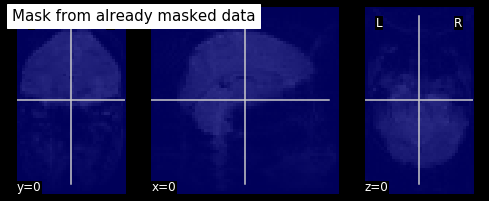

In [11]:
masker = NiftiMasker()
masker.fit(func_file)

# Plot the generated mask using the mask_img_ attribute
plot_roi(masker.mask_img_, mean_img, title="Mask from already masked data")

In [12]:
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,background
memory,Memory(location=None)
memory_level,1
reports,True


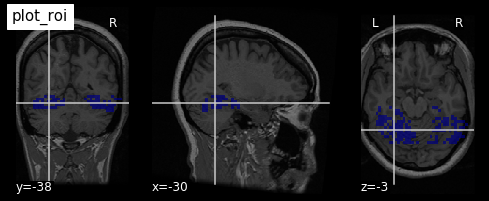

In [13]:
plotting.plot_roi(mask_vt_file, bg_img=anat_file, title="plot_roi")

In [14]:
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)
fmri_masked = masker.fit_transform(func_file)

# Report depict the computed mask
masker.generate_report()

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,/home/srastegarnia/nilearn_data/haxby2001/subj4/mask4_vt.nii.gz
mask_strategy,background
memory,Memory(location=None)
memory_level,1
reports,True


## ROI-based decoding analysis
In this section, I am looking at decoding accuracy for different objects in three different masks: the full ventral stream (mask_vt), the house selective areas (mask_house), and the face-selective areas (mask_face), that have been defined via a standard General Linear Model (GLM) based analysis.

In [15]:
# Load the behavioral data that I will predict
beh_label = pd.read_csv(haxby_ds.session_target[0], sep=" ")

# Preparing the data (Load target information as string and give a numerical identifier to each)
y = beh_label['labels']

# Identify the resting state
nonrest_task_mask = (y != 'rest')

# Remove the resting state and find names of remaining active labels
categories = y[nonrest_task_mask].unique()

# extract tags indicating to which acquisition run a tag belongs
session_labels = beh_label["chunks"][nonrest_task_mask]

In [ ]:
# The classifier: a support vector classifier
classifier = SVC(C=1., kernel="linear")

# A classifier to set the chance level
dummy_classifier = DummyClassifier()

# Make a data splitting object for cross validation
cv = LeaveOneGroupOut()

mask_names = ['mask_vt', 'mask_face', 'mask_house']

mask_scores = {}
mask_chance_scores = {}

for mask_name in mask_names:
    print("Working on mask %s" % mask_name)
    
    # Standardizing
    mask_filename = haxby_ds[mask_name][0]
    masker = NiftiMasker(mask_img=mask_filename, standardize=True)
    masked_timecourses = masker.fit_transform(func_file)[nonrest_task_mask]

    mask_scores[mask_name] = {}
    mask_chance_scores[mask_name] = {}

    for category in categories:
        print("Processing %s %s" % (mask_name, category))
        classification_target = (y[nonrest_task_mask] == category)
        mask_scores[mask_name][category] = cross_val_score(
            classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="roc_auc",
        )

        mask_chance_scores[mask_name][category] = cross_val_score(
            dummy_classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="roc_auc",
        )

        print("Scores: %1.2f +- %1.2f" % (
            mask_scores[mask_name][category].mean(),
            mask_scores[mask_name][category].std()))

Working on mask mask_vt
Processing mask_vt face


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.99 +- 0.01
Processing mask_vt chair


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.84 +- 0.14
Processing mask_vt scissors


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.85 +- 0.10
Processing mask_vt shoe


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.85 +- 0.10
Processing mask_vt scrambledpix


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.98 +- 0.03
Processing mask_vt house


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.99 +- 0.02
Processing mask_vt cat


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.85 +- 0.16
Processing mask_vt bottle


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.72 +- 0.21
Working on mask mask_face
Processing mask_face face


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.95 +- 0.05
Processing mask_face chair


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.65 +- 0.14
Processing mask_face scissors


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.73 +- 0.15
Processing mask_face shoe


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.71 +- 0.17
Processing mask_face scrambledpix


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.91 +- 0.07
Processing mask_face house


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.88 +- 0.10
Processing mask_face cat


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.76 +- 0.17
Processing mask_face bottle


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.51 +- 0.20
Working on mask mask_house
Processing mask_house face


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.95 +- 0.04
Processing mask_house chair


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.80 +- 0.12
Processing mask_house scissors


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.67 +- 0.17
Processing mask_house shoe


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.77 +- 0.08
Processing mask_house scrambledpix


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.96 +- 0.02
Processing mask_house house


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.98 +- 0.02
Processing mask_house cat


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.63 +- 0.18
Processing mask_house bottle


In [ ]:
# Visualizing the results as a bar plot
plt.figure()

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, mask_name in zip('ygc', mask_names):
    score_means = [mask_scores[mask_name][category].mean()
                   for category in categories]
    plt.bar(tick_position, score_means, label=mask_name,
            width=.25, color=color)

    score_chance = [mask_chance_scores[mask_name][category].mean()
                    for category in categories]
    plt.bar(tick_position, score_chance,
            width=.25, edgecolor='k', facecolor='none')

    tick_position = tick_position + .2
    

plt.ylabel('Classification accurancy (AUC score)')
plt.xlabel('Visual stimuli category')
plt.ylim(0.3, 1)
plt.legend(bbox_to_anchor=(1, 0.7))
plt.title('Category-specific classification accuracy for different masks')
plt.tight_layout()